# Rede Neural - Atualizada com GIT

## Instalação e import das dependências

In [ ]:
!pip install ucimlrepo

: 

In [2]:
import numpy as np
import pandas as pd
import kagglehub
import os
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

---
## Tratamento dos dados


In [3]:
# Função para normalizar os dados
def normalize(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

Download do dataset e tratamento dos dados de classificação binária

In [4]:
# Carregar o dataset do câncer
cancer_dataset_path = kagglehub.dataset_download("yasserh/breast-cancer-dataset")
cancer_dataset = os.listdir(cancer_dataset_path)[0]
cancer_csv = pandas.read_csv(os.path.join(cancer_dataset_path, cancer_dataset))

# Preparar os dados
df = cancer_csv.drop(columns=["id"])  # Remover coluna irrelevante
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})  # Mapear M/B para 1/0

# Selecionar variáveis independentes (X) e dependentes (y)
X = df.drop(columns=["diagnosis"]).values
y = df["diagnosis"].values.reshape(-1, 1)

# Dividindo o dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preparação dos dados (treinamento)
X_train_normalized = normalize(X_train)
y_train_normalized = y_train

# Preparação dos dados (teste)
X_test_normalized = normalize(X_test)
y_test_normalized = y_test

Download do dataset e tratamento dos dados de regressão

In [4]:
# Carregar o dataset de performance de estudantes
data_path = kagglehub.dataset_download('nikhil7280/student-performance-multiple-linear-regression')
dataset = os.listdir(data_path)[0]
data_csv = pd.read_csv(os.path.join(data_path, dataset))

# Selecionar variáveis independentes (X) e dependentes (y)
X = data_csv[['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']].values
y = data_csv['Performance Index'].values
y = normalize(y.reshape(-1, 1))

# Dividindo o dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preparação dos dados (treinamento)
X_train_normalized = normalize(X_train)
y_train_normalized = y_train

# Preparação dos dados (teste)
X_test_normalized = normalize(X_test)
y_test_normalized = y_test

Download do dataset e tratamento dos dados de classificação multiclasse

In [4]:
# Carregar o dataset do zoologico
zoo = fetch_ucirepo(id=111)

# Selecionar variáveis independentes (X) e dependentes (y)
X = zoo.data.features
y = zoo.data.targets

# Aplicando One-Hot Encoding
X = pd.get_dummies(X, columns=['legs'], prefix='legs', dtype=int)
y_onehot = pd.get_dummies(y, columns=['type'], prefix='type', dtype=int)

X = X.to_numpy()
y_onehot = y_onehot.to_numpy()

# Dividindo o dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

---
## Instanciando Rede Neural

### Iniciando funções de ativação

In [5]:
# Funções de ativação (ReLU para camadas ocultas, as outras para a saída)
def relu(z):
    return np.maximum(0, z)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(z):
    z = np.clip(z, -500, 500)  # Limita valores extremos p/ evitar overflow
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Para evitar overflow
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

* A função ReLU transforma todos os valores negativos em zero e mantém os valores positivos. É muito utilizada em redes neurais, especialmente nas camadas ocultas.
* A derivada da ReLU é usada na retropropagação. Ela retorna 1 se o valor for maior que zero e 0 caso contrário.
* A função sigmoid transforma os valores para um intervalo entre 0 e 1, frequentemente usada em problemas de classificação binária. O np.clip é usado para evitar valores extremos que podem causar overflow de exponenciação.
* A derivada da sigmoid é importante para a retropropagação. Ela calcula o gradiente da função em relação à sua entrada.
* A função linear não altera o valor, ou seja, ela simplesmente retorna a entrada. Usada em tarefas de regressão.
* A derivada da função linear é 1, pois a taxa de variação de uma reta é constante.
* A função softmax é usada em problemas de classificação multiclasse. Ela transforma os valores em probabilidades, onde a soma das probabilidades para todas as classes é 1. A subtração do np.max(z) ajuda a evitar overflow ao calcular exponenciais.

### Iniciando funções de perda

In [6]:
# Funções de perda
def mse_loss(y_true, y_pred): # Erro quadrático médio
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return -2 * (y_true - y_pred) / y_true.size

def binary_crossentropy_loss(y_true, y_pred): # Entropria cruzada binária
    epsilon = 1e-15  # Evitar log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_crossentropy_loss_derivative(y_true, y_pred):
    return y_pred - y_true

def categorical_crossentropy_loss(y_true, y_pred): # Entropria cruzada categórica
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def categorical_crossentropy_loss_derivative(y_true, y_pred):
    return y_pred - y_true

* O erro quadrático médio calcula a diferença entre o valor real e o valor predito, elevando ao quadrado para penalizar mais grandes erros.
* A derivada da função MSE é usada para calcular o gradiente durante a retropropagação.
* Cross-Entropy (binária e categórica): A função de perda de entropia cruzada é usada para problemas de classificação (binária e multiclasse). A ideia básica é que, se a probabilidade predita estiver próxima da verdadeira classe, a perda será pequena. Caso contrário, será grande.
* A derivada da entropria cruzada é utilizada durante a retropropagação.

### Iniciando estrutura da Rede Neural

In [7]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, output_activation='linear'):
        self.learning_rate = learning_rate
        self.output_activation = output_activation

        # Inicialização dos pesos e bias
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))

        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))

    def forward(self, X):
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output

        if self.output_activation == 'linear':
          self.final_output = linear(self.final_input)

        elif self.output_activation == 'sigmoid':
          self.final_output = sigmoid(self.final_input)

        elif self.output_activation == 'softmax':
          self.final_output = softmax(self.final_input)

        return self.final_output

    def backward(self, X, y, y_pred, loss_derivative):
        # Erro na saída
        if self.output_activation == 'linear':
          output_error = loss_derivative(y, y_pred) * linear_derivative(self.final_input)

        elif self.output_activation == 'sigmoid':
          output_error = loss_derivative(y, y_pred) * sigmoid_derivative(self.final_input)

        elif self.output_activation == 'softmax':
          output_error = loss_derivative(y, y_pred)

        # Gradientes para pesos e bias da saída
        weights_hidden_output_grad = np.dot(self.hidden_output.T, output_error)
        bias_output_grad = np.sum(output_error, axis=0, keepdims=True)

        # Erro na camada oculta
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * relu_derivative(self.hidden_input)

        # Gradientes para pesos e bias da camada oculta
        weights_input_hidden_grad = np.dot(X.T, hidden_error)
        bias_hidden_grad = np.sum(hidden_error, axis=0, keepdims=True)

        # Atualização dos pesos e biases
        self.weights_hidden_output -= self.learning_rate * weights_hidden_output_grad
        self.bias_output -= self.learning_rate * bias_output_grad

        self.weights_input_hidden -= self.learning_rate * weights_input_hidden_grad
        self.bias_hidden -= self.learning_rate * bias_hidden_grad

    def train(self, X_train, y_train, epochs, loss_function, loss_derivative, X_test=None, y_test=None):
        train_losses = []
        test_losses = []

        for epoch in range(epochs):
            # Forward
            y_train_pred = self.forward(X_train)

            # Cálculo do erro dos dados de treinamento
            train_loss = loss_function(y_train, y_train_pred)
            self.backward(X_train, y_train, y_train_pred, loss_derivative)
            train_losses.append(train_loss)

            # Cálculo do erro dos dados de teste sem atualização de parâmetros
            if X_test is not None and y_test is not None:
              y_test_pred = self.forward(X_test)
              test_loss = loss_function(y_test, y_test_pred)
              test_losses.append(test_loss)

            if epoch % 10 == 0:
                print(f"Epoch {epoch} -> Train Loss: {train_loss:.4f}, Test Loss: {test_loss if X_test is not None else 'N/A'}")

        return train_losses, test_losses

    def predict(self, X, type):
      if type == 'binary':
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)  # Classificação binária

      if type == 'multiclass':
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)  # Classificação multiclasse

1. `__init__`
* Parâmetros: Inicializa os parâmetros necessários (tamanho da entrada, tamanho da camada oculta, tamanho da saída, taxa de aprendizado, tipo de ativação da saída).
* Pesos e vieses: Os pesos são inicializados com valores aleatórios pequenos (multiplicados por 0.01 para evitar valores grandes), e os vieses são inicializados como zeros.

2. `forward`
* Entrada na camada oculta: A entrada X é multiplicada pelos pesos e somada com o viés.
* Ativação da camada oculta: A função ReLU é aplicada.
* Entrada na camada de saída: A saída da camada oculta é multiplicada pelos pesos da camada de saída e somada com o viés de saída.
* Função de ativação na camada de saída: A ativação apropriada é aplicada dependendo do parâmetro output_activation.

3. `backward`

A retropropagação calcula o erro da saída e propaga esse erro de volta para as camadas anteriores. Os gradientes para os pesos e vieses são calculados e depois usados para atualizar os parâmetros.

4. `train`

O método train treina o modelo em X_train e y_train por um número de epochs, calculando a perda para os dados de treinamento e, opcionalmente, para os dados de teste. A cada 50 épocas, o progresso é impresso.

Para classificação binária:
1. self.forward(X): A entrada X é passada pela rede para gerar as previsões. A função forward retorna os valores de saída da rede neural.
2. (y_pred > 0.5): A saída da rede geralmente estará no intervalo [0, 1] (como no caso de uma função de ativação sigmoide na camada de saída). O valor de 0.5 é usado como limiar. Se a previsão for maior que 0.5, a classe predita será 1, caso contrário, será 0.
3. O .astype(int): Converte as previsões para valores inteiros (0 ou 1).

5. `predict`

Para classificação multiclasse:
1. self.forward(X): Como na classificação binária, a entrada X passa pela rede e as previsões são geradas.
2. np.argmax(y_pred, axis=1): A rede neural gera uma distribuição de probabilidades para cada classe (geralmente com a função de ativação softmax na camada de saída).
3. O np.argmax retorna o índice da classe com a maior probabilidade, o que corresponde à previsão da classe final.

---
## Treinamento dos modelos

### Classificação binária

In [8]:
input_size = X_train_normalized.shape[1]
hidden_size = 10 # Camada oculta
output_size = y_train_normalized.shape[1] # Número de classes
learning_rate = 0.01 # Taxa de aprendizado
epochs = 100 # Épocas

Definindo hiperparâmetros

In [9]:
# Inicializando a rede neural
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate, output_activation='sigmoid')

# Treinando a rede
train_losses, test_losses = nn.train(X_train_normalized, y_train_normalized, epochs,
                                     binary_crossentropy_loss, binary_crossentropy_loss_derivative,
                                     X_test=X_test_normalized, y_test=y_test_normalized)

Epoch 0 -> Train Loss: 0.6930, Test Loss: 0.67608668219795
Epoch 10 -> Train Loss: 0.1711, Test Loss: 0.13688268561378825
Epoch 20 -> Train Loss: 0.0969, Test Loss: 0.08487834113403424
Epoch 30 -> Train Loss: 0.0776, Test Loss: 0.07104181979686548
Epoch 40 -> Train Loss: 0.0686, Test Loss: 0.06495774902836896
Epoch 50 -> Train Loss: 0.0631, Test Loss: 0.06171180287332237
Epoch 60 -> Train Loss: 0.0593, Test Loss: 0.05968366093998239
Epoch 70 -> Train Loss: 0.0564, Test Loss: 0.05848090221833126
Epoch 80 -> Train Loss: 0.0540, Test Loss: 0.05778551615889801
Epoch 90 -> Train Loss: 0.0519, Test Loss: 0.05737308471811462


A classe NeuralNetwork é instanciada com os hiperparâmetros definidos anteriormente.
A rede neural é treinada usando a função train, passando os dados de treino e teste, a função de perda (binary_crossentropy_loss) e sua derivada (binary_crossentropy_loss_derivative).

Acurácia no conjunto de dados de treinamento: 98.68%
Acurácia no conjunto de dados de teste: 98.25%


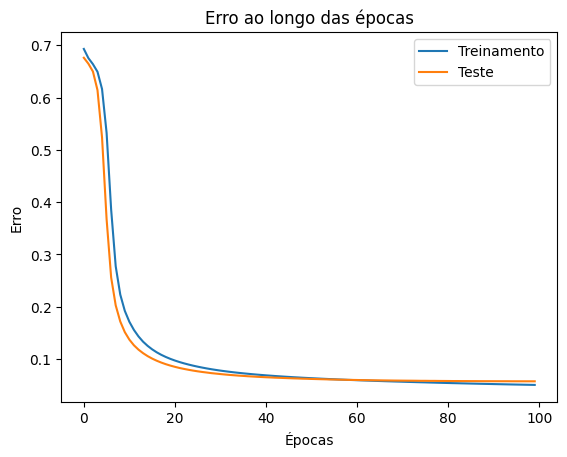

In [10]:
# Avaliação dos dados de treinamento
y_pred_train = nn.predict(X_train_normalized, 'binary')
accuracy_train = np.mean(y_pred_train == y_train_normalized) * 100
print(f"Acurácia no conjunto de dados de treinamento: {accuracy_train:.2f}%")

# Avaliação dos dados de teste
y_pred_test = nn.predict(X_test_normalized, 'binary')
accuracy_test = np.mean(y_pred_test == y_test_normalized) * 100
print(f"Acurácia no conjunto de dados de teste: {accuracy_test:.2f}%")

# Gráfico das perdas
plt.plot(train_losses, label="Treinamento")
plt.plot(test_losses, label="Teste")
plt.title("Erro ao longo das épocas")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.legend()
plt.show()

### Regressão

In [11]:
# Função para calcular o coeficiente de determinação (R2) para o problema de regressão
def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

Essa função calcula o coeficiente de determinação (R²), que é usado em regressão para medir a qualidade do ajuste do modelo.


In [12]:
input_size = X_train_normalized.shape[1]
hidden_size = 10 # Camada oculta
output_size = 1 # Número de classes
learning_rate = 0.1 # Taxa de aprendizado
epochs = 600 # Épocas


Definindo hiperparâmetros


In [13]:
# Inicializando a rede neural
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)

# Treinando a rede
train_losses, test_losses = nn.train(X_train_normalized, y_train_normalized, epochs,
                                     mse_loss, mse_loss_derivative,
                                     X_test=X_test_normalized, y_test=y_test_normalized)

Epoch 0 -> Train Loss: 0.9984, Test Loss: 1.003673132574136
Epoch 10 -> Train Loss: 0.9904, Test Loss: 0.9939390698634473
Epoch 20 -> Train Loss: 0.9135, Test Loss: 0.9003324207077302
Epoch 30 -> Train Loss: 0.5153, Test Loss: 0.47429748764245294
Epoch 40 -> Train Loss: 0.1376, Test Loss: 0.12888012157580994
Epoch 50 -> Train Loss: 0.0511, Test Loss: 0.05207711880015074
Epoch 60 -> Train Loss: 0.0351, Test Loss: 0.0357904226300312
Epoch 70 -> Train Loss: 0.0285, Test Loss: 0.02912612022658385
Epoch 80 -> Train Loss: 0.0253, Test Loss: 0.026013711279205723
Epoch 90 -> Train Loss: 0.0238, Test Loss: 0.02445975025464412
Epoch 100 -> Train Loss: 0.0230, Test Loss: 0.023637581531612682
Epoch 110 -> Train Loss: 0.0226, Test Loss: 0.02315814690243411
Epoch 120 -> Train Loss: 0.0222, Test Loss: 0.022793614683753342
Epoch 130 -> Train Loss: 0.0219, Test Loss: 0.02246474507522062
Epoch 140 -> Train Loss: 0.0215, Test Loss: 0.022118992374685734
Epoch 150 -> Train Loss: 0.0212, Test Loss: 0.021755

A classe NeuralNetwork é instanciada com os hiperparâmetros definidos anteriormente. A rede neural é treinada usando a função train, passando os dados de treino e teste, a função de perda (mse_loss) e sua derivada (mse_loss_derivative).

Coeficiente de Determinação (R2) - treinamento: 0.9879944088668245
Coeficiente de Determinação (R2) - teste: 0.9876634590452805


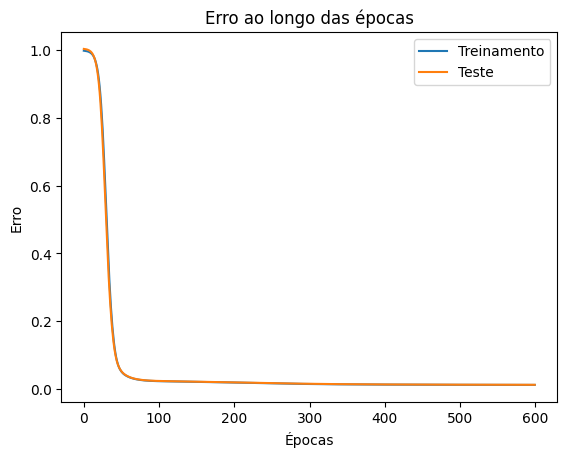

In [14]:
# Avaliação dos dados de treinamento
y_train_pred = nn.forward(X_train_normalized)
r2_train = r2_score(y_train_normalized, y_train_pred)
print(f"Coeficiente de Determinação (R2) - treinamento: {r2_train}")

# Avaliação dos dados de teste
y_test_pred = nn.forward(X_test_normalized)
r2_test = r2_score(y_test_normalized, y_test_pred)
print(f"Coeficiente de Determinação (R2) - teste: {r2_test}")

# Gráfico das perdas
plt.plot(train_losses, label="Treinamento")
plt.plot(test_losses, label="Teste")
plt.title("Erro ao longo das épocas")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.legend()
plt.show()

### Classificação multiclasse

In [8]:
input_size = X_train.shape[1]
hidden_size = 250 # Camada oculta
output_size = y_train.shape[1]  # Número de classes
learning_rate = 0.01 # Taxa de aprendizado
epochs = 70 # Épocas

Definindo hiperparâmetros

In [9]:
# Inicializando a rede neural
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate, output_activation='softmax')

# Treinando a rede
train_losses, test_losses = nn.train(X_train, y_train, epochs,
                                     categorical_crossentropy_loss,
                                     categorical_crossentropy_loss_derivative,
                                     X_test=X_test, y_test=y_test)

Epoch 0 -> Train Loss: 1.9468, Test Loss: 1.837982110712854
Epoch 10 -> Train Loss: 0.9514, Test Loss: 0.7473212097287136
Epoch 20 -> Train Loss: 0.5351, Test Loss: 0.4878334672638152
Epoch 30 -> Train Loss: 0.3227, Test Loss: 0.3093544482560399
Epoch 40 -> Train Loss: 0.1914, Test Loss: 0.19778841041223988
Epoch 50 -> Train Loss: 0.1233, Test Loss: 0.15819850946262476
Epoch 60 -> Train Loss: 0.0851, Test Loss: 0.14562264829130314


A classe NeuralNetwork é instanciada com os hiperparâmetros definidos anteriormente mais a função de ativação que, nesse caso, é softmax. A rede neural é treinada usando a função train, passando os dados de treino e teste, a função de perda (categorical_crossentropy_loss) e sua derivada (categorical_crossentropy_loss_derivative).

Acurácia no conjunto de dados de treinamento: 100.00%
Acurácia no conjunto de dados de teste: 95.24%


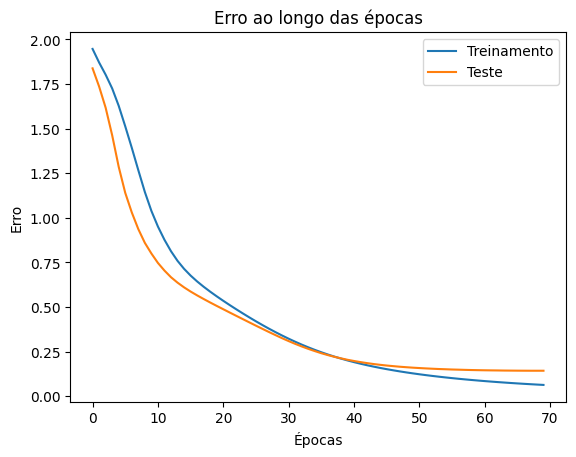

In [10]:
# Avaliação dos dados de treinamento
y_pred_train = nn.predict(X_train, 'multiclass')
accuracy_train = np.mean(np.argmax(y_train, axis=1) == y_pred_train) * 100
print(f"Acurácia no conjunto de dados de treinamento: {accuracy_train:.2f}%")

# Avaliação dos dados de teste
y_pred_test = nn.predict(X_test, 'multiclass')
accuracy_test = np.mean(np.argmax(y_test, axis=1) == y_pred_test) * 100
print(f"Acurácia no conjunto de dados de teste: {accuracy_test:.2f}%")

# Gráfico das perdas
plt.plot(train_losses, label="Treinamento")
plt.plot(test_losses, label="Teste")
plt.title("Erro ao longo das épocas")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.legend()
plt.show()